# NYC Motor Vehicle Collision Analysis

This notebook analyzes collision data from the NYC Open Data API, including crashes, vehicles, and persons involved.

**Data Sources:**
- Crashes: Basic collision information
- Vehicles: Detailed vehicle and driver data
- Persons: Individual-level injury and safety data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Load environment and connect to database
load_dotenv()
POSTGRES_URL = os.getenv('POSTGRES_URL')
if not POSTGRES_URL:
    raise RuntimeError('POSTGRES_URL not set in .env')

engine = create_engine(POSTGRES_URL)
print('✅ Connected to PostgreSQL!')

✅ Connected to PostgreSQL!


## 1. Overview - Collision Summary

Query the main `collision_summary` table for high-level statistics.

In [2]:
# Query collision summary
query = text('SELECT * FROM collision_summary ORDER BY crash_day DESC LIMIT 20')

with engine.connect() as conn:
    df_summary = pd.read_sql(query, conn)

print(f'Total rows in collision_summary: {len(df_summary)}')
df_summary.head(10)

Total rows in collision_summary: 20


,borough,crash_day,total_collisions,injury_incidents,fatal_incidents,total_persons_injured,total_persons_killed,pedestrians_injured,pedestrians_killed,cyclists_injured,cyclists_killed,motorists_injured,motorists_killed
0,BRONX,2024-12-31,28,12,0,13,0,6,0,1,0,5,0
1,BROOKLYN,2024-12-31,76,42,2,53,2,15,1,3,0,35,1
2,QUEENS,2024-12-31,42,19,0,21,0,6,0,1,0,11,0
3,STATEN ISLAND,2024-12-31,12,7,0,9,0,3,0,0,0,6,0
4,MANHATTAN,2024-12-31,31,16,0,17,0,5,0,3,0,9,0
5,QUEENS,2024-12-30,52,30,0,33,0,8,0,5,0,19,0
6,MANHATTAN,2024-12-30,46,20,0,22,0,13,0,1,0,6,0
7,BROOKLYN,2024-12-30,71,32,0,42,0,6,0,3,0,33,0
8,BRONX,2024-12-30,19,12,0,15,0,4,0,0,0,10,0
9,STATEN ISLAND,2024-12-30,4,2,0,4,0,0,0,0,0,4,0


In [3]:
# Overall statistics
with engine.connect() as conn:
    stats_query = text("""
        SELECT 
            SUM(total_collisions) as total_crashes,
            SUM(total_persons_injured) as total_injured,
            SUM(total_persons_killed) as total_killed,
            SUM(pedestrians_injured) as ped_injured,
            SUM(cyclists_injured) as cyclist_injured,
            SUM(motorists_injured) as motorist_injured
        FROM collision_summary
    """)
    stats = pd.read_sql(stats_query, conn)

print('=== NYC Collision Statistics (Since Oct 1, 2024) ===')
print(f"Total Crashes: {stats['total_crashes'][0]:,}")
print(f"Total Injured: {stats['total_injured'][0]:,}")
print(f"Total Killed: {stats['total_killed'][0]:,}")
print(f"\nBreakdown by Road User Type:")
print(f"  Pedestrians Injured: {stats['ped_injured'][0]:,}")
print(f"  Cyclists Injured: {stats['cyclist_injured'][0]:,}")
print(f"  Motorists Injured: {stats['motorist_injured'][0]:,}")

=== NYC Collision Statistics (Since Oct 1, 2024) ===
Total Crashes: 65,228.0
Total Injured: 36,197.0
Total Killed: 160.0

Breakdown by Road User Type:
  Pedestrians Injured: 7,806.0
  Cyclists Injured: 4,128.0
  Motorists Injured: 22,806.0


## 2. Geographic Analysis - Collisions by Borough

In [4]:
# Borough statistics
with engine.connect() as conn:
    borough_query = text("""
        SELECT 
            borough,
            SUM(total_collisions) as crashes,
            SUM(total_persons_injured) as injured,
            SUM(total_persons_killed) as killed
        FROM collision_summary
        GROUP BY borough
        ORDER BY crashes DESC
    """)
    df_borough = pd.read_sql(borough_query, conn)

df_borough

,borough,crashes,injured,killed
0,BROOKLYN,22785.0,13152.0,53.0
1,QUEENS,17811.0,9938.0,31.0
2,MANHATTAN,11904.0,5779.0,32.0
3,BRONX,10032.0,6026.0,33.0
4,STATEN ISLAND,2696.0,1302.0,11.0


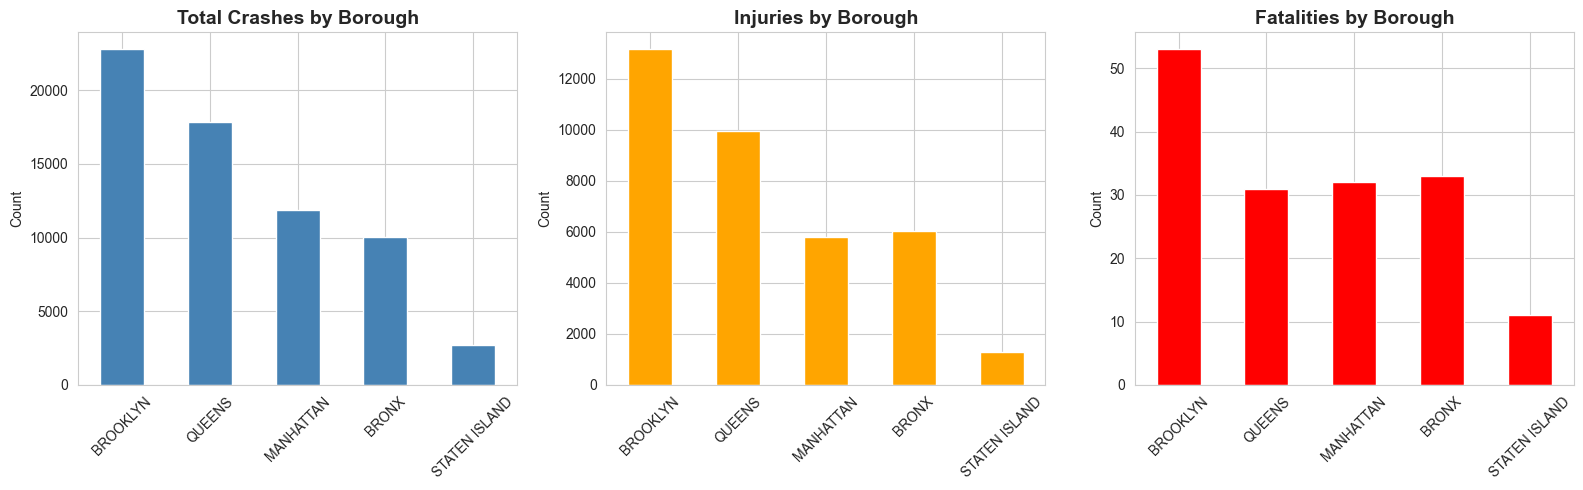

In [5]:
# Visualize borough data
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

df_borough.plot(x='borough', y='crashes', kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Total Crashes by Borough', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

df_borough.plot(x='borough', y='injured', kind='bar', ax=axes[1], color='orange', legend=False)
axes[1].set_title('Injuries by Borough', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)

df_borough.plot(x='borough', y='killed', kind='bar', ax=axes[2], color='red', legend=False)
axes[2].set_title('Fatalities by Borough', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Count')
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Temporal Patterns - When Do Collisions Happen?

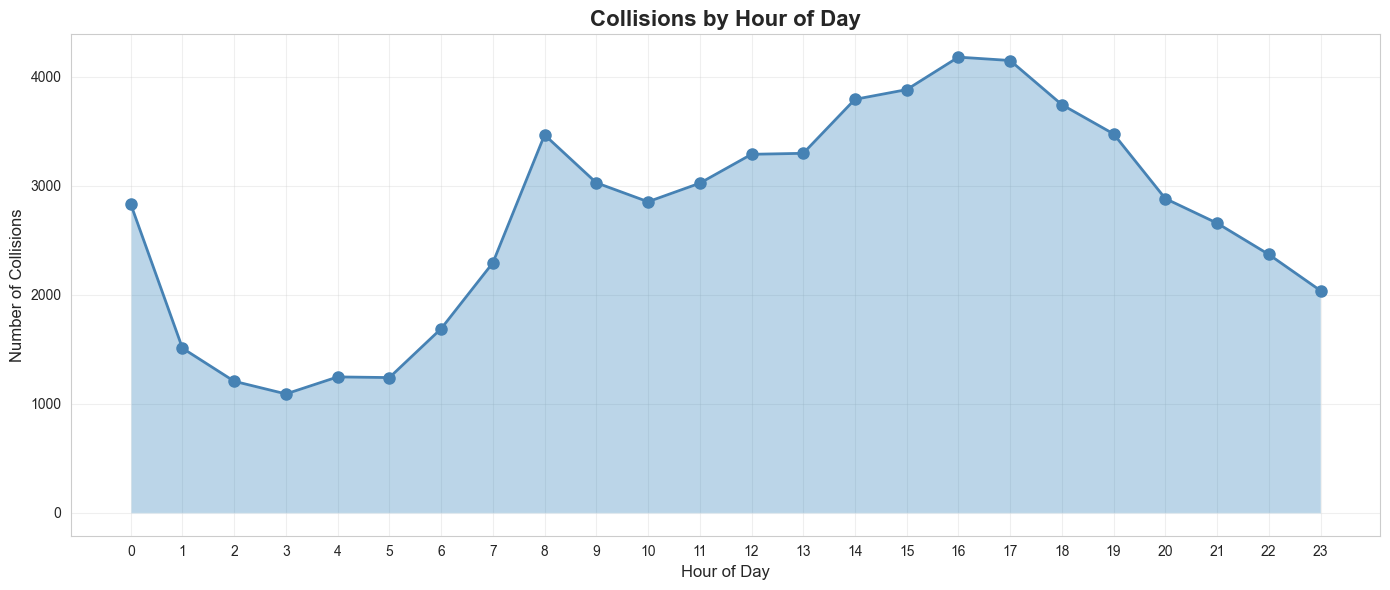

Peak hour: 16:00 with 4,179.0 crashes
Safest hour: 3:00 with 1,091.0 crashes


In [6]:
# Hourly patterns
with engine.connect() as conn:
    hourly_query = text("""
        SELECT 
            hour_of_day,
            SUM(total_collisions) as crashes,
            SUM(total_injured) as injured
        FROM collision_by_hour
        GROUP BY hour_of_day
        ORDER BY hour_of_day
    """)
    df_hourly = pd.read_sql(hourly_query, conn)

# Plot hourly patterns
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df_hourly['hour_of_day'], df_hourly['crashes'], marker='o', linewidth=2, markersize=8, color='steelblue')
ax.fill_between(df_hourly['hour_of_day'], df_hourly['crashes'], alpha=0.3)
ax.set_title('Collisions by Hour of Day', fontsize=16, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Number of Collisions', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24))
plt.tight_layout()
plt.show()

print(f"Peak hour: {df_hourly.loc[df_hourly['crashes'].idxmax(), 'hour_of_day']:.0f}:00 with {df_hourly['crashes'].max():,} crashes")
print(f"Safest hour: {df_hourly.loc[df_hourly['crashes'].idxmin(), 'hour_of_day']:.0f}:00 with {df_hourly['crashes'].min():,} crashes")

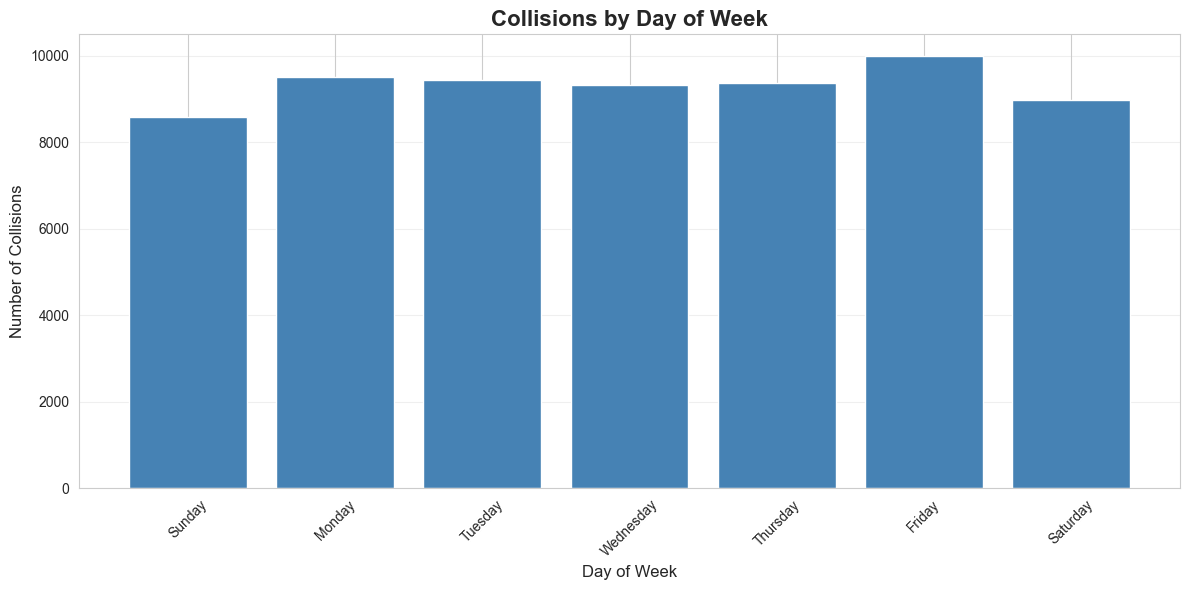

In [7]:
# Day of week patterns
with engine.connect() as conn:
    dow_query = text("""
        SELECT 
            day_num,
            TRIM(day_of_week) as day_of_week,
            SUM(total_collisions) as crashes,
            SUM(total_injured) as injured
        FROM collision_by_weekday
        GROUP BY day_num, day_of_week
        ORDER BY day_num
    """)
    df_dow = pd.read_sql(dow_query, conn)

# Plot day of week
plt.figure(figsize=(12, 6))
plt.bar(df_dow['day_of_week'], df_dow['crashes'], color='steelblue')
plt.title('Collisions by Day of Week', fontsize=16, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Number of Collisions', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Contributing Factors - What Causes Collisions?

In [8]:
# Top contributing factors
with engine.connect() as conn:
    factors_query = text("""
        SELECT 
            factor,
            collision_count,
            total_injured,
            total_killed,
            injury_rate_pct
        FROM contributing_factors_summary
        ORDER BY collision_count DESC
        LIMIT 15
    """)
    df_factors = pd.read_sql(factors_query, conn)

df_factors

,factor,collision_count,total_injured,total_killed,injury_rate_pct
0,Driver Inattention/Distraction,22205,13347,30,45.60
1,Failure to Yield Right-of-Way,6281,5547,22,72.81
2,Following Too Closely,5438,3792,1,46.93
3,Passing or Lane Usage Improper,3731,1714,8,34.31
4,Unsafe Speed,3443,2784,30,50.60
5,Passing Too Closely,2977,617,1,15.49
6,Other Vehicular,2870,1623,4,37.28
7,Backing Unsafely,2743,761,1,24.13
8,Traffic Control Disregarded,2604,2537,20,65.71
9,Turning Improperly,2148,1096,1,38.64


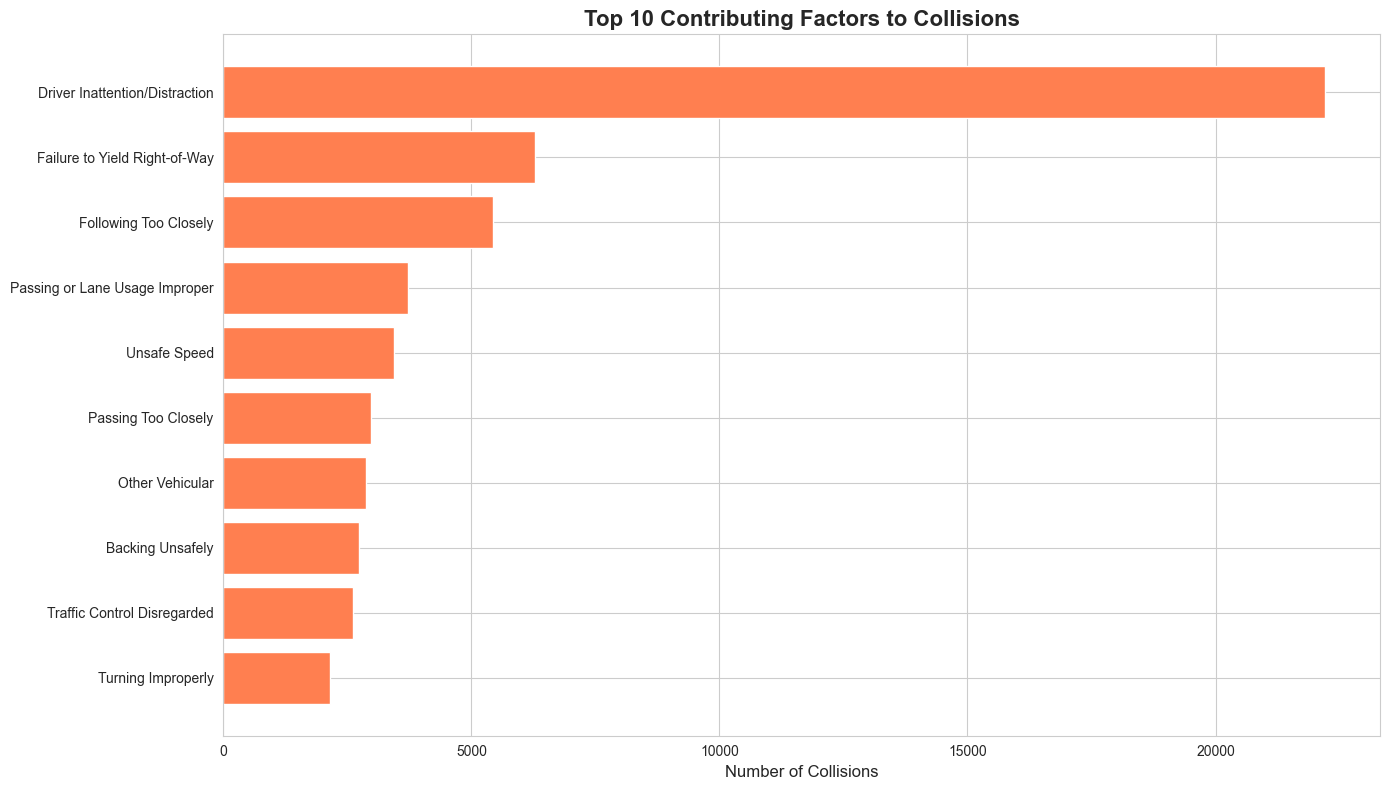

In [9]:
# Visualize top factors
plt.figure(figsize=(14, 8))
plt.barh(df_factors['factor'].head(10), df_factors['collision_count'].head(10), color='coral')
plt.xlabel('Number of Collisions', fontsize=12)
plt.title('Top 10 Contributing Factors to Collisions', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 5. Vehicle Analysis - Vehicle Types and Safety

In [10]:
# Vehicle type analysis
with engine.connect() as conn:
    vehicle_query = text("""
        SELECT 
            vehicle_type,
            collision_count,
            total_injuries,
            injury_rate_pct
        FROM vehicle_type_analysis
        ORDER BY collision_count DESC
        LIMIT 10
    """)
    df_vehicles = pd.read_sql(vehicle_query, conn)

print('Top Vehicle Types Involved in Collisions:')
df_vehicles

Top Vehicle Types Involved in Collisions:


,vehicle_type,collision_count,total_injuries,injury_rate_pct
0,Sedan,70018,43778,54.45
1,Station Wagon/Sport Utility Vehicle,54067,34759,54.47
2,Bike,5596,4999,86.66
3,Pick-up Truck,4227,2455,40.61
4,Taxi,3963,2931,55.65
5,Box Truck,3479,1663,30.53
6,Bus,3436,1802,32.98
7,Moped,1998,1781,77.39
8,Motorcycle,1896,1586,73.26
9,E-Bike,1751,1567,83.50


In [11]:
# Driver license status impact
with engine.connect() as conn:
    license_query = text("""
        SELECT * FROM driver_license_analysis
        ORDER BY crash_count DESC
    """)
    df_license = pd.read_sql(license_query, conn)

print('\nCrashes by Driver License Status:')
df_license


Crashes by Driver License Status:


,driver_license_status,crash_count,total_injured,total_killed,injury_rate_pct
0,Licensed,104396,77750,284,49.32
1,Unlicensed,4017,3442,66,64.48
2,Permit,2113,1835,8,62.66


## 6. Safety Equipment Analysis - Does It Save Lives?

In [12]:
# Safety equipment effectiveness
with engine.connect() as conn:
    safety_query = text("""
        SELECT 
            safety_equipment,
            person_type,
            person_count,
            injured_count,
            killed_count,
            injury_rate_pct,
            fatality_rate_pct
        FROM safety_equipment_analysis
        WHERE person_type = 'Occupant'
        ORDER BY person_count DESC
    """)
    df_safety = pd.read_sql(safety_query, conn)

print('Safety Equipment Effectiveness (Vehicle Occupants):')
df_safety

Safety Equipment Effectiveness (Vehicle Occupants):


,safety_equipment,person_type,person_count,injured_count,killed_count,injury_rate_pct,fatality_rate_pct
0,Lap Belt & Harness,Occupant,76723,17054,8,22.24,0.0104
1,Lap Belt,Occupant,28350,6172,1,21.77,0.0035
2,Child Restraint Only,Occupant,1888,455,0,24.10,0.0000
3,Helmet (Motorcycle Only),Occupant,1774,1416,20,80.95,1.1274
4,Air Bag Deployed/Lap Belt/Harness,Occupant,1273,648,5,51.30,0.3928
5,Other,Occupant,964,125,1,13.07,0.1037
6,Air Bag Deployed,Occupant,857,467,3,54.84,0.3501
7,Harness,Occupant,690,138,0,20.00,0.0000
8,Air Bag Deployed/Lap Belt,Occupant,338,196,3,58.88,0.8876
9,Helmet Only (In-Line Skater/Bicyclist),Occupant,153,123,2,81.70,1.3072


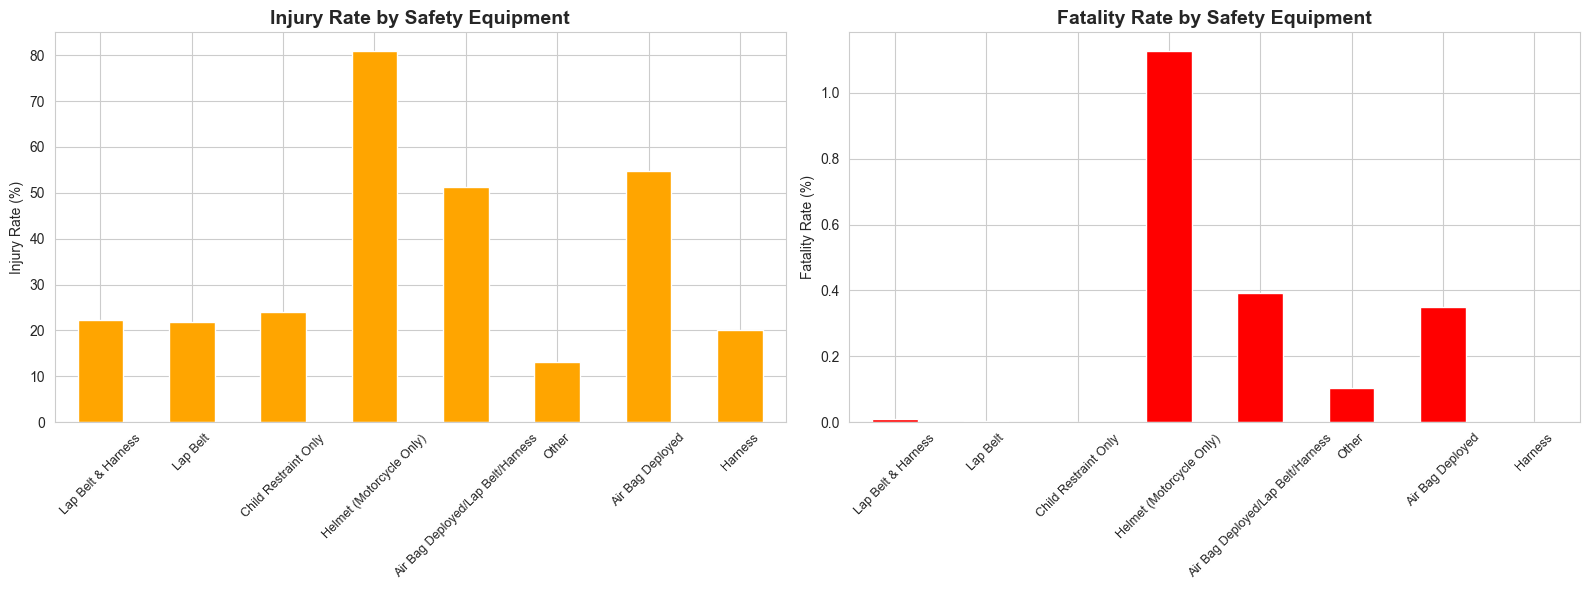

In [13]:
# Visualize safety equipment impact
if len(df_safety) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Injury rate
    df_safety.head(8).plot(x='safety_equipment', y='injury_rate_pct', kind='bar', ax=axes[0], color='orange', legend=False)
    axes[0].set_title('Injury Rate by Safety Equipment', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Injury Rate (%)')
    axes[0].set_xlabel('')
    axes[0].tick_params(axis='x', rotation=45, labelsize=9)
    
    # Fatality rate
    df_safety.head(8).plot(x='safety_equipment', y='fatality_rate_pct', kind='bar', ax=axes[1], color='red', legend=False)
    axes[1].set_title('Fatality Rate by Safety Equipment', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Fatality Rate (%)')
    axes[1].set_xlabel('')
    axes[1].tick_params(axis='x', rotation=45, labelsize=9)
    
    plt.tight_layout()
    plt.show()

## 7. Vulnerable Road Users - Pedestrians & Cyclists

In [14]:
# Person type analysis
with engine.connect() as conn:
    person_query = text("""
        SELECT 
            person_type,
            SUM(person_count) as total_persons,
            SUM(injured_count) as total_injured,
            SUM(killed_count) as total_killed,
            ROUND(AVG(injury_rate_pct), 2) as avg_injury_rate
        FROM person_type_analysis
        GROUP BY person_type
        ORDER BY total_persons DESC
    """)
    df_person_type = pd.read_sql(person_query, conn)

print('Casualties by Road User Type:')
df_person_type

Casualties by Road User Type:


,person_type,total_persons,total_injured,total_killed,avg_injury_rate
0,Occupant,199613.0,22855.0,49.0,11.19
1,Pedestrian,8409.0,7892.0,86.0,93.71
2,Bicyclist,4971.0,4147.0,19.0,84.32
3,Other Motorized,1709.0,1463.0,6.0,85.77


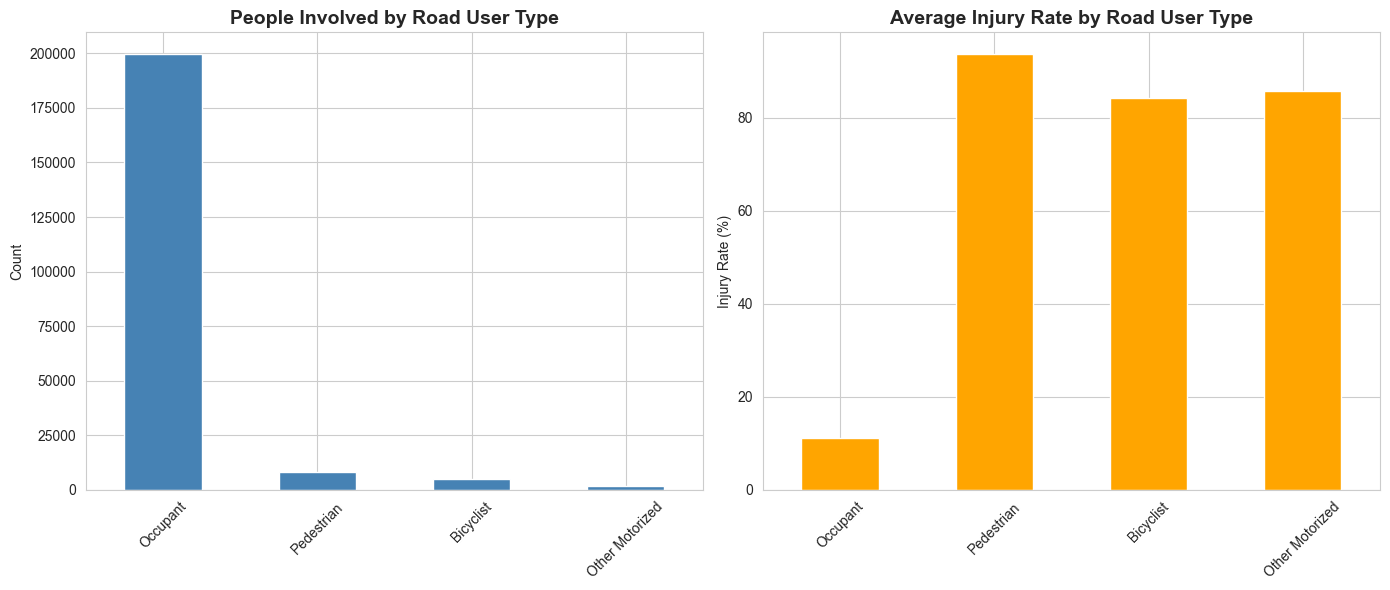

In [15]:
# Visualize vulnerable users
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Total persons
df_person_type.plot(x='person_type', y='total_persons', kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('People Involved by Road User Type', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('')
axes[0].tick_params(axis='x', rotation=45)

# Injury rate
df_person_type.plot(x='person_type', y='avg_injury_rate', kind='bar', ax=axes[1], color='orange', legend=False)
axes[1].set_title('Average Injury Rate by Road User Type', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Injury Rate (%)')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 8. Age & Demographics

In [16]:
# Age group vulnerability
with engine.connect() as conn:
    age_query = text("""
        SELECT 
            age_group,
            SUM(person_count) as total,
            SUM(injured) as injured,
            SUM(killed) as killed,
            ROUND(AVG(injury_rate_pct), 2) as avg_injury_rate
        FROM age_group_analysis
        WHERE age_group != 'Unknown'
        GROUP BY age_group
        ORDER BY 
            CASE age_group
                WHEN 'Under 18' THEN 1
                WHEN '18-30' THEN 2
                WHEN '31-50' THEN 3
                WHEN '51-70' THEN 4
                WHEN '70+' THEN 5
            END
    """)
    df_age = pd.read_sql(age_query, conn)

print('Injury Risk by Age Group:')
df_age

Injury Risk by Age Group:


,age_group,total,injured,killed,avg_injury_rate
0,Under 18,15200.0,4585.0,16.0,63.97
1,18-30,64542.0,16191.0,62.0,57.86
2,31-50,111628.0,20664.0,77.0,56.58
3,51-70,61643.0,9756.0,80.0,56.47
4,70+,11187.0,2149.0,31.0,53.79


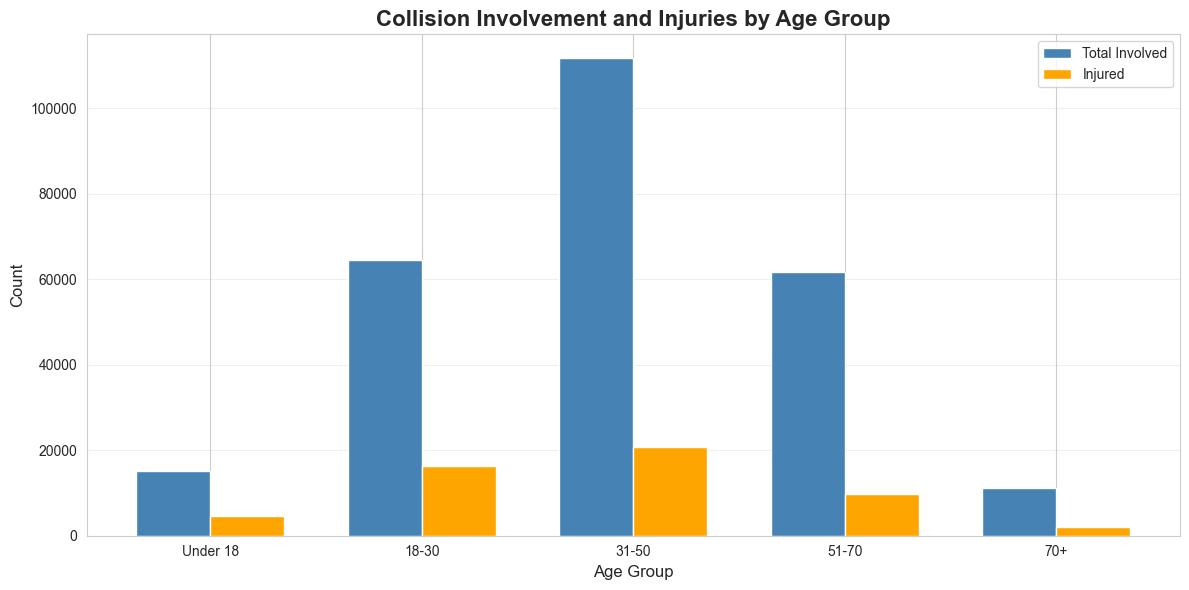

In [17]:
# Visualize age vulnerability
plt.figure(figsize=(12, 6))
x = range(len(df_age))
width = 0.35

plt.bar([i - width/2 for i in x], df_age['total'], width, label='Total Involved', color='steelblue')
plt.bar([i + width/2 for i in x], df_age['injured'], width, label='Injured', color='orange')

plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Collision Involvement and Injuries by Age Group', fontsize=16, fontweight='bold')
plt.xticks(x, df_age['age_group'])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Custom Queries - Explore the Data

In [18]:
# Example: Find the most dangerous zip codes
with engine.connect() as conn:
    dangerous_zips = text("""
        SELECT 
            zip_code,
            borough,
            collision_count,
            total_injured,
            total_killed,
            injury_rate_pct
        FROM collision_hotspots_zip
        ORDER BY collision_count DESC
        LIMIT 10
    """)
    df_dangerous_zips = pd.read_sql(dangerous_zips, conn)

print('Top 10 Most Dangerous Zip Codes:')
df_dangerous_zips

Top 10 Most Dangerous Zip Codes:


,zip_code,borough,collision_count,total_injured,total_killed,injury_rate_pct
0,11207.0,BROOKLYN,1588,1019,4,64.17
1,11236.0,BROOKLYN,1067,812,3,76.10
2,11208.0,BROOKLYN,1029,576,0,55.98
3,11212.0,BROOKLYN,980,573,2,58.47
4,11203.0,BROOKLYN,915,613,1,66.99
5,11226.0,BROOKLYN,899,610,3,67.85
6,11234.0,BROOKLYN,860,580,2,67.44
7,11385.0,QUEENS,830,423,0,50.96
8,11101.0,QUEENS,830,438,2,52.77
9,11368.0,QUEENS,823,458,0,55.65


In [19]:
# Example: Rush hour vs off-peak safety
with engine.connect() as conn:
    rush_hour = text("""
        SELECT 
            time_period,
            SUM(collision_count) as crashes,
            SUM(total_injured) as injured,
            ROUND(AVG(avg_injuries_per_collision), 2) as avg_injuries
        FROM rush_hour_analysis
        GROUP BY time_period
        ORDER BY crashes DESC
    """)
    df_rush = pd.read_sql(rush_hour, conn)

print('\nCollisions by Time Period:')
df_rush


Collisions by Time Period:


,time_period,crashes,injured,avg_injuries
0,Off-Peak,27362.0,15193.0,0.55
1,Evening Rush (4-7 PM),15545.0,9587.0,0.60
2,Night (10 PM-5 AM),13535.0,7131.0,0.50
3,Morning Rush (7-9 AM),8786.0,4286.0,0.49


## Summary

This notebook demonstrates direct querying of the `collision_summary` table and other analytical tables created by the ELT pipeline.

**Available Tables:**
- `collision_summary` - Daily collision statistics by borough
- `collision_by_hour` - Hourly patterns
- `collision_by_weekday` - Day of week patterns
- `contributing_factors_summary` - Causes of collisions
- `vehicle_type_analysis` - Vehicle safety analysis
- `safety_equipment_analysis` - Safety equipment effectiveness
- `person_type_analysis` - Vulnerable road user analysis
- `age_group_analysis` - Age-based vulnerability
- And 16 more analytical tables!

**Next Steps:**
- Explore other tables in the database
- Create custom queries for specific analyses
- Build dashboards or reports from the data